In [18]:
%load_ext autoreload
%autoreload 2
#%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import signal
import time
from sklearn.utils import shuffle

from waflgp import *
import utils 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
N_trials = 50
def make_dict():
    dic={'periodogram-None':[],
                     'periodogram-hann':[],
                     'periodogram-hamming':[],
                     'bartlett-None':[],
                     'bartlett-hann':[],
                     'bartlett-hamming':[],
                     'welch-None':[],
                     'welch-hann':[],
                     'welch-hamming':[]}
    return dic

## Spectral mixture example

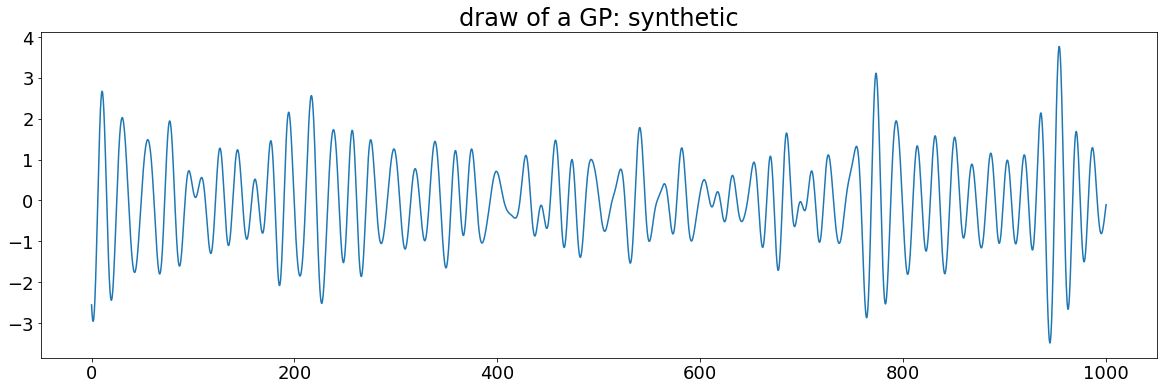

In [20]:
# generate
# synthetic data (GP sample with SM kernel)
np.random.seed(0)


t0 = 0
tf = 1000
Nobs = 4000
times = np.linspace(t0,tf,Nobs)
gp0 = waflgp(space_input=times, aim = 'sampling', kernel = 'SM')
gp0.sigma_n = 0.001
l_freq = 0.01
gamma_freq = 1/(2*l_freq**2)
gp0.gamma = np.pi**2/gamma_freq
mu_freq = 0.05
gp0.mu = mu_freq
    
    
    
#sample
values = gp0.sample(times)
gp0.time_label = 'time'
gp0.signal_label = 'synthetic'
plt.figure(figsize=(20,6))
plt.plot(times, values)
plt.title(f'draw of a GP: {gp0.signal_label}');


### Spectral mixture

In [ ]:
muSM = make_dict()
lsSM = make_dict()
muSMn = make_dict()
lsSMn = make_dict()

for trial in range(N_trials):
    #uniform sampling
    l_freq = 0.01 + np.random.rand()*0.01
    gp0.delta = l_freq
    mu_freq = 0.025 + np.random.rand()*0.05
    gp0.mu = mu_freq
    values = gp0.sample(times)
    
    
    times_train, values_train = times[1::2], values[1::2]
    
    for method in ['periodogram', 'bartlett', 'welch']:
        for window in [None, 'hann', 'hamming']:
            gp = waflgp(space_input=times_train,  space_output=values_train, aim = 'learning', kernel = 'SM')
            gp.train_WL(method = method, window = window, nbins = 10)
            S_true = np.exp(-1/2/l_freq**2*(gp.freqs-mu_freq)**2)
            S_true = S_true/np.sum(S_true)/(gp.freqs[1]-gp.freqs[0])
            title_str = f'Learnt parameters are loc: {gp.theta[0]:.4f}, scale: {gp.theta[1]:.4f}'
            #gp.plot_psd(title = title_str, f_true = gp.freqs,S_true = S_true,label_true = 'Ground truth Exp-cos kernel')
            muSM[f'{method}-{window}'].append((np.abs(gp.theta[0]- mu_freq)/mu_freq)) 
            lsSM[f'{method}-{window}'].append((np.abs(gp.theta[1] - l_freq)/l_freq)) 
            #plt.savefig(f'Paper/img/effect_SM_{method}_{window}.pdf', bbox_inches='tight')
            
    #non-uniform samplig
    #times_train, values_train = shuffle(times, values)
    #times_train, values_train = times_train[1::2], values_train[1::2]

    #for method in ['periodogram', 'bartlett', 'welch']:
    #    for window in [None, 'hann', 'hamming']:
    #        gp = waflgp(space_input=times_train,  space_output=values_train, aim = 'learning', kernel = 'SM')
    #        gp.train_WL(method = method, window = window, nbins = 10)
    #        S_true = 1/np.sqrt(2*np.pi*l_freq**2)*np.exp(-1/2/l_freq**2*(gp.freqs-mu_freq)**2)
    #        S_true = S_true/np.sum(S_true)/(gp.freqs[1]-gp.freqs[0])
    #        title_str = f'Learnt parameters are loc: {gp.theta[0]:.4f}, scale: {gp.theta[1]:.4f}'
    #        #gp.plot_psd(title = title_str, f_true = gp.freqs,S_true = S_true,label_true = 'Ground truth Exp-cos kernel')
    #        muSMn[f'{method}-{window}'].append(gp.theta[0]) 
    #        lsSMn[f'{method}-{window}'].append(gp.theta[1]) 
            #plt.savefig(f'Paper/img/effect_SM_n_{method}_{window}.pdf', bbox_inches='tight')

In [15]:
print('Spectral mixture - uniform sampling\n')
for k,v in muSM.items():
    print(f'{k}: location:{100*np.mean(muSM[k]):.4f}±{100*np.std(muSM[k]):.4f}, scale:{100*np.mean(lsSM[k]):.4f}±{100*np.std(lsSM[k]):.4f}')

print('\nFor latex script:\n')
    
for k,v in muSM.items():
    print(f'{k}: {100*np.mean(muSM[k]):.2f}\p{100*np.std(muSM[k]):.2f}/{100*np.mean(lsSM[k]):.2f}\p{100*np.std(lsSM[k]):.2f}')
    
#print('\n\nSpectral mixture - nonuniform sampling\n')
#for k,v in muSMn.items():
#    print(f'{k}: location:{100*np.mean(muSMn[k]):.4f}±{100*np.std(muSMn[k]):.4f}, scale:{100*np.mean(lsSMn[k]):.4f}±{100*np.std(lsSMn[k]):.4f}')

Spectral mixture - uniform sampling

periodogram-None: location:2.3031±1.6137, scale:33.4137±13.2734
periodogram-hann: location:2.9847±2.1417, scale:34.9289±14.3321
periodogram-hamming: location:2.9179±2.0416, scale:34.9320±14.1631
bartlett-None: location:2.1747±1.9100, scale:20.8838±11.6950
bartlett-hann: location:3.0224±2.3614, scale:26.2280±13.0454
bartlett-hamming: location:2.9269±2.2908, scale:27.3509±13.2621
welch-None: location:2.0468±1.6430, scale:24.8712±14.3537
welch-hann: location:2.5172±1.7515, scale:31.8272±13.2933
welch-hamming: location:2.4881±1.7255, scale:32.2567±13.2187

For latex script:

periodogram-None: 2.30\p1.61/33.41\p13.27
periodogram-hann: 2.98\p2.14/34.93\p14.33
periodogram-hamming: 2.92\p2.04/34.93\p14.16
bartlett-None: 2.17\p1.91/20.88\p11.69
bartlett-hann: 3.02\p2.36/26.23\p13.05
bartlett-hamming: 2.93\p2.29/27.35\p13.26
welch-None: 2.05\p1.64/24.87\p14.35
welch-hann: 2.52\p1.75/31.83\p13.29
welch-hamming: 2.49\p1.73/32.26\p13.22


## Sinc  example

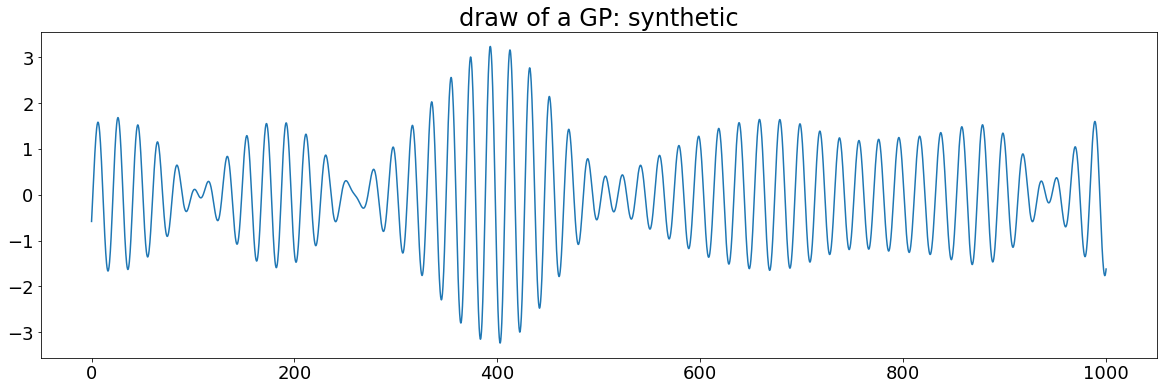

In [6]:
# generate
# synthetic data (GP sample with sinc kernel)
np.random.seed(0)

t0 = 0
tf = 1000
Nobs = 4000
times = np.linspace(t0,tf,Nobs)
gp0 = waflgp(space_input=times, aim = 'sampling', kernel = 'sinc')
#gp.sigma_n = 0.001
l_freq = 0.01
gp0.delta = l_freq
mu_freq = 0.05
gp0.mu = mu_freq
    
    
    
#sample
values = gp0.sample(times)
gp0.time_label = 'time'
gp0.signal_label = 'synthetic'
plt.figure(figsize=(20,6))
plt.plot(times, values)
plt.title(f'draw of a GP: {gp0.signal_label}');

### Sinc

In [7]:
muSI = make_dict()
lsSI = make_dict()
muSIn = make_dict()
lsSIn = make_dict()

for trial in range(N_trials):
    values = gp0.sample(times)
    
    #uniform sampling
    l_freq = 0.01 + np.random.rand()*0.01
    gp0.delta = l_freq
    mu_freq = 0.025 + np.random.rand()*0.05
    gp0.mu = mu_freq
    values = gp0.sample(times)
    times_train, values_train = times[1::2], values[1::2]
    
    
    for window in [None, 'hann', 'hamming']:
        for method in ['periodogram', 'bartlett', 'welch']:    
            gp = waflgp(space_input=times_train,  space_output=values_train, aim = 'learning', kernel = 'sinc')
            gp.train_WL(method = method, window = window, nbins = 10)
            S_true = utils.Rect(gp.freqs, l_freq,mu_freq)
            S_true = S_true/np.sum(S_true)/(gp.freqs[1]-gp.freqs[0])
            title_str = f'Learnt parameters are loc: {gp.theta[0]:.4f}, scale: {gp.theta[1]:.4f}'
            #gp.plot_psd(title = title_str, f_true = gp.freqs,S_true = S_true,label_true = 'Ground truth Sinc kernel')
            muSI[f'{method}-{window}'].append((np.abs(gp.theta[0]- mu_freq)/mu_freq)) 
            lsSI[f'{method}-{window}'].append((np.abs(gp.theta[1] - l_freq)/l_freq)) 
            #plt.savefig(f'Paper/img/effect_sinc_{method}_{window}.pdf', bbox_inches='tight')
            
    #non-uniform sampling   
    #times_train, values_train = shuffle(times, values)
    #times_train, values_train = times_train[1::2], values_train[1::2]
    
    #for method in ['periodogram', 'bartlett', 'welch']:
    #    for window in [None, 'hann', 'hamming']:
    #        gp = waflgp(space_input=times_train,  space_output=values_train, aim = 'learning', kernel = 'sinc')
    #        gp.train_WL(method = method, window = window, nbins = 10)
    #        S_true = utils.Rect(gp.freqs, l_freq,mu_freq)
    #        S_true = S_true/np.sum(S_true)/(gp.freqs[1]-gp.freqs[0])
    #        title_str = f'Learnt parameters are loc: {gp.theta[0]:.4f}, scale: {gp.theta[1]:.4f}'
    #        #gp.plot_psd(title = title_str, f_true = gp.freqs,S_true = S_true,label_true = 'Ground truth Sinc kernel')
    #        muSIn[f'{method}-{window}'].append(gp.theta[0]) 
    #        lsSIn[f'{method}-{window}'].append(gp.theta[1]) 
    #        #plt.savefig(f'Paper/img/effect_sinc_n_{method}_{window}.pdf', bbox_inches='tight')

In [17]:
print('Sinc - uniform sampling\n')
for k,v in muSI.items():
    print(f'{k}: location:{100*np.mean(muSI[k]):.4f}±{100*np.std(muSI[k]):.4f}, scale:{100*np.mean(lsSI[k]):.4f}±{100*np.std(lsSI[k]):.4f}')
    
    
print('\n for Latex script\n')
for k,v in muSI.items():
    print(f'{k}: {100*np.mean(muSI[k]):.2f}\p{100*np.std(muSI[k]):.2f}/{100*np.mean(lsSI[k]):.2f}\p{100*np.std(lsSI[k]):.2f}')
    
#print('\n\nSinc - nonuniform sampling\n')
#for k,v in muSIn.items():
#    print(f'{k}: location:{100*np.mean(muSIn[k]):.4f}±{100*np.std(muSIn[k]):.4f}, scale:{100*np.mean(lsSIn[k]):.4f}±{100*np.std(lsSIn[k]):.4f}')

Sinc - uniform sampling

periodogram-None: location:2.3636±1.6467, scale:8.9346±6.7290
periodogram-hann: location:2.6781±2.0169, scale:10.0342±9.2224
periodogram-hamming: location:2.5987±2.0093, scale:9.6228±8.9322
bartlett-None: location:2.6314±2.2343, scale:83.2348±26.3889
bartlett-hann: location:2.5854±1.7694, scale:58.8575±17.4789
bartlett-hamming: location:2.5637±1.7544, scale:50.6177±15.7899
welch-None: location:2.3130±1.7652, scale:38.8711±15.9458
welch-hann: location:2.4359±1.7763, scale:19.5247±11.3160
welch-hamming: location:2.4290±1.7625, scale:16.5066±10.7464

 for Latex script

periodogram-None: 2.36\p1.65/8.93\p6.73
periodogram-hann: 2.68\p2.02/10.03\p9.22
periodogram-hamming: 2.60\p2.01/9.62\p8.93
bartlett-None: 2.63\p2.23/83.23\p26.39
bartlett-hann: 2.59\p1.77/58.86\p17.48
bartlett-hamming: 2.56\p1.75/50.62\p15.79
welch-None: 2.31\p1.77/38.87\p15.95
welch-hann: 2.44\p1.78/19.52\p11.32
welch-hamming: 2.43\p1.76/16.51\p10.75
